In [1]:
import sys
sys.path.append("../")

import torch
import timeit
import numpy as np
import pickle
from models.RDPG_GD_Unroll_unshared_normalized_v2 import GD_Unroll as GD_Unroll_w_norm
from models.RDPG_GD import RDPG_GD_Armijo, coordinate_descent
from models.SVD_truncate import embed_scipy
from torch_geometric.utils import to_dense_adj, stochastic_blockmodel_graph, erdos_renyi_graph
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
## Load model

device = 'cuda'
d = 3
gd_steps = 5

lase_full = GD_Unroll_w_norm(d, d, gd_steps)
lase_full.load_state_dict(torch.load('../saved_models/lase_unshared_d3_normalized__full.pt'))
lase_full.to(device)
lase_full.eval()

lase_ER05 = GD_Unroll_w_norm(d, d, gd_steps)
lase_ER05.load_state_dict(torch.load('../saved_models/lase_unshared_d3_normalized__ER05.pt'))
lase_ER05.to(device)
lase_ER05.eval()

lase_ER03 = GD_Unroll_w_norm(d, d, gd_steps)
lase_ER03.load_state_dict(torch.load('../saved_models/lase_unshared_d3_normalized__ER03.pt'))
lase_ER03.to(device)
lase_ER03.eval()

def measure_execution_time(func, *args, loops=5, repetitions=5) -> float:
    best_time = float('inf')
    for _ in range(repetitions):
        loop_time = timeit.timeit(lambda: func(*args), number=loops)
        best_time = min(best_time, loop_time / loops)
    return best_time

p = [
     [0.5, 0.1, 0.3],
     [0.1, 0.9, 0.2], 
     [0.3, 0.2, 0.7]
]

# SVD

In [3]:
nodes = np.arange(5,55,5)*100

svd_exec_time = []

for num_nodes in nodes:
    print(num_nodes)
    n = [int(num_nodes/3), int(num_nodes/3), int(num_nodes/3)]
    edge_index = stochastic_blockmodel_graph(n, p)
    best_time = measure_execution_time(embed_scipy, edge_index, d, device)
    svd_exec_time.append(best_time)
    print(f"Best execution time over 5 repetitions: {best_time:.8f} seconds")

500
Best execution time over 5 repetitions: 0.04522535 seconds
1000
Best execution time over 5 repetitions: 0.02973399 seconds
1500
Best execution time over 5 repetitions: 0.06064570 seconds
2000
Best execution time over 5 repetitions: 0.10909492 seconds
2500
Best execution time over 5 repetitions: 0.17129105 seconds
3000
Best execution time over 5 repetitions: 0.24704140 seconds
3500
Best execution time over 5 repetitions: 0.37045051 seconds
4000
Best execution time over 5 repetitions: 0.43052906 seconds
4500
Best execution time over 5 repetitions: 0.53941179 seconds
5000
Best execution time over 5 repetitions: 0.64002103 seconds


In [12]:
with open('../data/svd_performance.pkl', 'wb') as f:
    pickle.dump(svd_exec_time, f)

# Coordinate GD

In [4]:
nodes = np.arange(5,55,5)*100

cgd_exec_time = []

for num_nodes in nodes:
    print(num_nodes)
    n = [int(num_nodes/3), int(num_nodes/3), num_nodes - 2*int(num_nodes/3)]
    edge_index = stochastic_blockmodel_graph(n, p).to(device)
    mask = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
    best_time = measure_execution_time(coordinate_descent, edge_index, mask, d, device)
    cgd_exec_time.append(best_time)
    print(f"Best execution time over 5 repetitions: {best_time:.8f} seconds")

500
Best execution time over 5 repetitions: 0.20343107 seconds
1000
Best execution time over 5 repetitions: 0.40929902 seconds
1500
Best execution time over 5 repetitions: 0.61030412 seconds
2000
Best execution time over 5 repetitions: 0.83075829 seconds
2500
Best execution time over 5 repetitions: 1.13172004 seconds
3000
Best execution time over 5 repetitions: 1.26280253 seconds
3500
Best execution time over 5 repetitions: 1.71190278 seconds
4000
Best execution time over 5 repetitions: 1.95409945 seconds
4500
Best execution time over 5 repetitions: 2.21992135 seconds
5000
Best execution time over 5 repetitions: 2.48500740 seconds


In [5]:
with open('../data/coord_gd_performance.pkl', 'wb') as f:
    pickle.dump(cgd_exec_time, f)

# LASE Full

In [58]:
nodes = np.arange(5,55,5)*100

lase_full_exec_time = []

for num_nodes in nodes:
    print(num_nodes)
    n = [int(num_nodes/3), int(num_nodes/3), num_nodes - 2*int(num_nodes/3)]
    x = torch.rand((num_nodes, d)).to(device)
    edge_index = stochastic_blockmodel_graph(n, p).to(device)
    edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
    mask = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
    best_time = measure_execution_time(lase_full, x, edge_index, edge_index_2, mask)
    lase_full_exec_time.append(best_time)
    print(f"Best execution time over 5 repetitions: {best_time:.8f} seconds")

500
Best execution time over 5 repetitions: 0.02005730 seconds
1000
Best execution time over 5 repetitions: 0.05363282 seconds
1500
Best execution time over 5 repetitions: 0.10523354 seconds
2000
Best execution time over 5 repetitions: 0.17249300 seconds
2500
Best execution time over 5 repetitions: 0.25885197 seconds
3000
Best execution time over 5 repetitions: 0.35988931 seconds
3500
Best execution time over 5 repetitions: 0.48306959 seconds
4000
Best execution time over 5 repetitions: 0.62010075 seconds
4500
Best execution time over 5 repetitions: 0.77745784 seconds
5000
Best execution time over 5 repetitions: 0.94819430 seconds


In [59]:
with open('../data/lase_full_performance.pkl', 'wb') as f:
    pickle.dump(lase_full_exec_time, f)

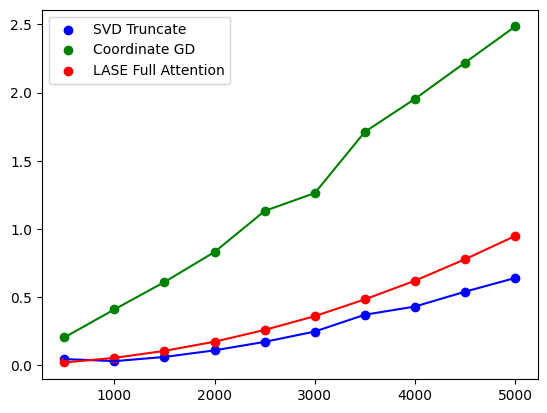

In [13]:
with open('../data/svd_performance.pkl', 'rb') as f:
    svd_exec_time = pickle.load(f)

with open('../data/coord_gd_performance.pkl', 'rb') as f:
    cgd_exec_time = pickle.load(f)

with open('../data/lase_full_performance.pkl', 'rb') as f:
    lase_full_exec_time = pickle.load(f)

plt.figure()
plt.scatter(nodes, svd_exec_time, c ='blue', label = 'SVD Truncate')
plt.plot(nodes, svd_exec_time, c ='blue')
plt.scatter(nodes, cgd_exec_time, c ='green', label = 'Coordinate GD')
plt.plot(nodes, cgd_exec_time, c ='green')
plt.scatter(nodes, lase_full_exec_time, c ='red', label = 'LASE Full Attention')
plt.plot(nodes, lase_full_exec_time, c ='red')
plt.legend()
plt.show()

For nodes > 5000 we do not have enough GPU compute, so we need to run on CPU

In [23]:
nodes = np.arange(5,16)*1000
device = 'cpu'

lase_full.to(device)

lase_full_exec_time = []

for num_nodes in nodes:
    print(num_nodes)
    n = [int(num_nodes/3), int(num_nodes/3), num_nodes - 2*int(num_nodes/3)]
    x = torch.rand((num_nodes, d)).to(device)
    edge_index = stochastic_blockmodel_graph(n, p).to(device)
    edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
    mask = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
    best_time = measure_execution_time(lase_full, x, edge_index, edge_index_2, mask)
    lase_full_exec_time.append(best_time)
    print(f"Best execution time over 5 repetitions: {best_time:.8f} seconds")


with open('../data/lase_full_performance_2.pkl', 'wb') as f:
    pickle.dump(lase_full_exec_time, f)

5000
Best execution time over 5 repetitions: 8.25732689 seconds
6000
Best execution time over 5 repetitions: 11.95300788 seconds
7000
Best execution time over 5 repetitions: 16.31878564 seconds
8000
Best execution time over 5 repetitions: 21.34957191 seconds
9000
